
**任务描述：** 
>利用nltk语料库中的影评来进行朴素贝叶斯情感分类训练。

**影评导入：** 
>from nltk.corpus import movie_reviews  
>文件具体目录在…\nltk_data\corpora\movie_reviews，已做好分类标注，消极与积极影评各1000 条。

**步骤：** 
>经过文本预处理（去噪、分句、分词、去停词、取词干、修剪）和特征选择，生成特
征词表，之后利用朴素贝叶斯模型进行训练。（每个步骤最好注释一下）
选择前 80%（即前 800 条消极影评与前 800 条积极影评）作为训练集，后 20%作为测试集。

**输出：** 
>准确率 Accuracy，精确率 Precision，召回率 Recall 和 F1 值，精确到小数点后两位。  
其中，F1 = ( 2 * Precision * Recall ) / ( Precision + Recall)。

**例如：**  
>Accuracy = 0.98  
Precision = 0.67  
Recall = 0.32  
F1 = 0.43

***

#### 第一步 读入数据

In [3]:
from nltk.corpus import movie_reviews

all_words = movie_reviews.words()
#for i in range(len(all_words)):
 #   print(i, all_words[i])
print(len(all_words))

1583820


***
#### 第二步 文本预处理（参考作业二）
 标准化，即全部小写、去标点、去停用词，并提取词干or词形还原。

In [2]:
import re
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

def prepro(token):
    normalisation = []
    
    #转为小写 sub函数顺便把标点也去掉了，代码参考本人提交的homework2
    pattern=re.compile("[^a-zA-Z0-9\n ]")
    f = open('norm.txt', 'w')
    for i in range(len(token)): #读出单个字符串
        temp = re.sub(pattern, "", token[i]).lower()
        if(temp not in stopwords.words('english')\
            and temp != ''):
            # print(i, temp)
            normalisation.append(temp)
            f.write(temp+'\n')
    #消标点 -- 标准化的时候已经处理好这些东西了
    #处理停用词
    f.close()# 读进文件免得跑一次7分钟太久
    return normalisation

pro_words = prepro(all_words)
# print(pro_words)


print("\n\n",len(pro_words))



 708455


In [6]:


print(pro_words[0])

plot


## 词干提取，词形还原从上文的函数拆开放入到下面的函数

In [5]:
from nltk.stem.porter import PorterStemmer

def prepro_ps(token):
    PS = [] #词干提取
    f = open("PS.txt", 'w')
    stemmer = PorterStemmer()
    for i in range(len(token)):
        ste = stemmer.stem(token[i])
        PS.append(ste)
        f.write(ste + '\n')
    f.close()
    return PS

from nltk.stem import WordNetLemmatizer
def prepro_wnln(token):
    WNL_N = [] #词形还原n
    f = open("WNLN.txt", 'w')
    lem = WordNetLemmatizer()
    for i in token:
        nlem = lem.lemmatize(i, pos = 'n')
        WNL_N.append(nlem)
        f.write(nlem + '\n')
    f.close()
    return WNL_N

def prepro_wnlv(token):
    WNL_V = [] #词形还原v
    f = open("WNLV.txt", 'w')
    lem = WordNetLemmatizer()
    for i in token:
        vlem = lem.lemmatize(i, pos = 'v')
        WNL_V.append(vlem)
        f.write(vlem + '\n')
    f.close()
    return WNL_V




# PS = prepro_ps(pro_words)
# WLNN = prepro_wnln(pro_words)
# WLNV = prepro_wnlv(pro_words)

PS = []
WLNN = []
WLNV = []
with  open('PS.txt', 'r') as input_file:
    while True:
        line = input_file.readline()
        if not line: 
            break
        PS.append(line.rstrip())
with  open('WNLN.txt', 'r') as input_file:
    while True:
        line = input_file.readline()
        if not line: 
            break
        WLNN.append(line.rstrip())
with  open('WNLV.txt', 'r') as input_file:
    while True:
        line = input_file.readline()
        if not line: 
            break
        WLNV.append(line.rstrip())


print(len(PS)," ", len(WLNN)," ", len(WLNV))

708455   708455   708455


In [6]:
# 快速获得 PS WLN
# 避免每次运行都需要7分钟
test = []
with  open('norm.txt', 'r') as input_file:
    while True:
        line = input_file.readline()
        if not line: 
            break
        test.append(line.rstrip())
        #print(line)
print(len(test))

PS = prepro_ps(test)
WLNN = prepro_wnln(test)
WLNV = prepro_wnlv(test)
print(len(PS)," ", len(WLNN)," ", len(WLNV))

708455
708455   708455   708455


***
#### 第三步 特征选择

In [7]:
import nltk

# 特征选择，取词频前5%或前2000个词。

pro_words = PS.copy()
#pro_words = WLNN.copy()
#pro_words = WLNV.copy()


freq_words = nltk.FreqDist(pro_words)
n = int( 0.05 * len(freq_words.keys() ))
workds_features_5per = list(freq_words.keys())[:n]
workds_features_2000 = list(freq_words.keys())[:2000]

***
#### 第四步 生成词表

In [8]:
def doc_features(doc):
    # 去重复
    doc_words = set(doc) 
    features = {}
    for word in workds_features_5per:
        # word 在不在总此表中 向量化
        features['contains(%s)' % word] = (word in doc_words)
        #看标注集的单词是否在这个句子里面
        #5per单词都拿出来看看这个句子里面有没有出现对应的这些词
    return features

documents = [(list(movie_reviews.words(fileid)),category)
            for category in movie_reviews.categories()  # 类别
            for fileid in movie_reviews.fileids(category)] # 文件名
# for i in documents:
#     for j in i:
#         print(j, '')
#     print()
# documents是一个列表，里面存的是大小为2的元组
# 元组的0位置是一个元组，存了若干个单词；1位置表示消极积极
featuresets = [(doc_features(d),c) for (d,c) in documents]

# for i in featuresets:
#     for j in i:
#         print(j, '')
#     print()

#featuresets吧本来的docments的前半部分转换为去重的部分
    # featureset有多个“句子”
    # 句子里面的单词都被标注了是neg还是pos
    # 于是统计句子里面的单词是否都出现在workds_features_5per中
## 去重并向量化


In [12]:
#print(documents[0])
print(len(featuresets))
# for i in range(len(featuresets)):
#     print(len(featuresets[i]))

2000


***
#### 第五步 划分数据集

In [9]:
train_set = featuresets[0:800] + featuresets[1000:1800]
test_set = featuresets[800:1000] + featuresets[1800:2000]



print(len(train_set[0][0]), type(train_set[0][0]))
print(len(train_set[0][1]), type(train_set[0][1]))
# print(len(train_set[0][1]))
print(len(train_set[0]), type(train_set[0]))
print(len(train_set), type(train_set))



1290 <class 'dict'>
3 <class 'str'>
2 <class 'tuple'>
1600 <class 'list'>


***
#### 第六步 模型训练

In [27]:
# 自己实现
import numpy as np
#首先先把数据转换成numpy，方便后续运算

# trainset[0][0]是一个dict
    # transet[0][0] key 是1290个次
    # transet[0][0] values 是 1290次是否存在在句子里面
    # transet[0][1] 是句子的感情
    # transet[0] 就是 [0]和[1]的tuple
    # trainset 存1600个tuple

#trainsets吧本来的docments的前半部分转换为去重的部分
    # trainset有多个“句子”
    # 句子里面的单词都被标注了是neg还是pos
    # 于是统计句子里面的单词是否都出现在workds_features_5per中
def train_plain_bayes(train_set):
    num_of_sen = len(train_set)
    num_of_words = len(train_set[0][0])
    
    sum_of_cato = 0
    for i in train_set:
        if i[1] == 'pos':
            sum_of_cato += 1 #统计有多少个pos句子
    pAbusive = sum_of_cato * 1.0 / num_of_sen

    posNum = np.ones(num_of_words)#设为1避免单词未出现导致出现log0的情况
    negNum = np.ones(num_of_words)
    posDeno = 1.0
    negDeno = 1.0
    for i in range(num_of_sen): #分类
        tempList = list(train_set[i][0].values())
        if (train_set[i][1] == 'pos'): 
            #如果句子是积极的，对应的1290个单词都得累加
            tempDeno = 0
            for j in range(len(tempList)):
                posNum[j] += tempList[j] # 积极语句哪些单词出现的多？
                tempDeno += tempList[j]
            posDeno += tempDeno #积极语句出现的词频
        elif(train_set[i][1] == 'neg'): 
            tempDeno = 0
            for j in range(len(tempList)):
                negNum[j] += tempList[j]
                tempDeno += tempList[j]
            negDeno += tempDeno
    # print(type(posNum))
    posVec = np.log(posNum / posDeno)
    negVec = np.log(negNum / negDeno)
    return posVec, negVec, pAbusive

#测试集处理转化为numpy
def test_plain_bayes(test_set):
    num_of_sen = len(test_set)
    num_of_words = len(test_set[0][0])
    mid_data = []

    for i in range(num_of_sen):
        Num = np.zeros(num_of_words) # 测试集设为0而非1
        tempList = list(test_set[i][0].values())
        for j in range(num_of_words):
            Num[j] += tempList[j]
        mid_data.append(Num)
    return mid_data

# 分类器
def classify_plain_bayes(arr, posVec, negVec, pAbusive):
    pos = sum(arr * posVec) + np.log(pAbusive)
    neg = sum(arr * negVec) + np.log(pAbusive)
    if pos > neg:
        return "pos"
    else:
        return "neg"





In [22]:
# 修改一下前文的细节看看实现效果是否有出入
# 吧POSNUM和NEGNUM数据调小一点测试，发现与实际出入不大
import numpy as np


def train_plain_bayes(train_set):
    num_of_sen = len(train_set)
    num_of_words = len(train_set[0][0])
    
    sum_of_cato = 0
    for i in train_set:
        if i[1] == 'pos':
            sum_of_cato += 1 #统计有多少个pos句子
    pAbusive = sum_of_cato * 1.0 / num_of_sen
#这里不设1，设为0看看结果
    posNum = np.zeros(num_of_words)
    
    negNum = np.zeros(num_of_words)
    for i in range(len(posNum)):
        posNum[i] = 0.01
        negNum[i] = 0.01
    posDeno = 1.0
    negDeno = 1.0
    for i in range(num_of_sen): #分类
        tempList = list(train_set[i][0].values())
        if (train_set[i][1] == 'pos'): 
            #如果句子是积极的，对应的1290个单词都得累加
            tempDeno = 0
            for j in range(len(tempList)):
                posNum[j] += tempList[j] # 积极语句哪些单词出现的多？
                tempDeno += tempList[j]
            posDeno += tempDeno #积极语句出现的词频
        elif(train_set[i][1] == 'neg'): 
            tempDeno = 0
            for j in range(len(tempList)):
                negNum[j] += tempList[j]
                tempDeno += tempList[j]
            negDeno += tempDeno
    # print(type(posNum))
    posVec = np.log(posNum / posDeno)
    negVec = np.log(negNum / negDeno)
    return posVec, negVec, pAbusive

#测试集处理转化为numpy
def test_plain_bayes(test_set):
    num_of_sen = len(test_set)
    num_of_words = len(test_set[0][0])
    mid_data = []

    for i in range(num_of_sen):
        Num = np.zeros(num_of_words) # 测试集设为0而非1
        tempList = list(test_set[i][0].values())
        for j in range(num_of_words):
            Num[j] += tempList[j]
        mid_data.append(Num)
    return mid_data

# 分类器
def classify_plain_bayes(arr, posVec, negVec, pAbusive):
    pos = sum(arr * posVec) + np.log(pAbusive)
    neg = sum(arr * negVec) + np.log(pAbusive)
    if pos > neg:
        return "pos"
    else:
        return "neg"





In [23]:
# 测试

posV, negV, ab = train_plain_bayes(train_set = train_set)
print(posV), print(negV), print(ab)
TS = test_plain_bayes(test_set = test_set)

prediction = []
for i in range(len(TS)):
    temp = classify_plain_bayes(TS[i], posV, negV, ab)
    #print(i, temp)
    prediction.append(temp)
# print(prediction)
# print(TS)

[ -5.23210975  -4.90505849  -7.23863837 ... -15.5576245   -7.81652541
  -9.56366307]
[ -4.92811682  -4.89437949  -7.08904816 ... -15.54457869  -7.8034796
  -8.74107343]
0.5


***
#### 第七步 模型评估

In [24]:
import collections
from nltk import precision,recall,f_measure


reality = []
for i in test_set:
    reality.append(i[1])
# print(reality)
four = [0.0] * 4
ref = dict(neg = 0, pos = 1)
for i in range(len(reality)):
    a = 2 * ref[prediction[i]] + ref[reality[i]]
    # 实际占低
    four[a] += 1

argu = dict(zip(['TN', 'FN', 'FP', 'TP'], four))
print(argu)

#精确率、召回率、FI
evaluation = []
pre = argu['TP'] / (argu['TP'] + argu['TN'])
evaluation.append(("pre", pre))
rec = argu['TP'] / (argu['TP'] + argu['FN'])
evaluation.append(("rec", rec))
acc = (argu['TP'] + argu['TN'])/ sum(four)
evaluation.append(("acc", acc))
# F1 = 2 * pre * rec / (pre + rec)
# evaluation.append(("F1", F1))

for a in list(range(1,6)) + list(range(10, 50, 10)) :
    F = ((a**2 + 1) * pre * rec) / (a**2 * (pre + rec))
    evaluation.append(("F" + str(a), F))



print(evaluation)


{'TN': 150.0, 'FN': 53.0, 'FP': 50.0, 'TP': 147.0}
[('pre', 0.494949494949495), ('rec', 0.735), ('acc', 0.7425), ('F1', 0.5915492957746479), ('F2', 0.369718309859155), ('F3', 0.32863849765258224), ('F4', 0.31426056338028174), ('F5', 0.3076056338028169), ('F10', 0.2987323943661972), ('F20', 0.29651408450704225), ('F30', 0.29610328638497657), ('F40', 0.29595950704225354)]


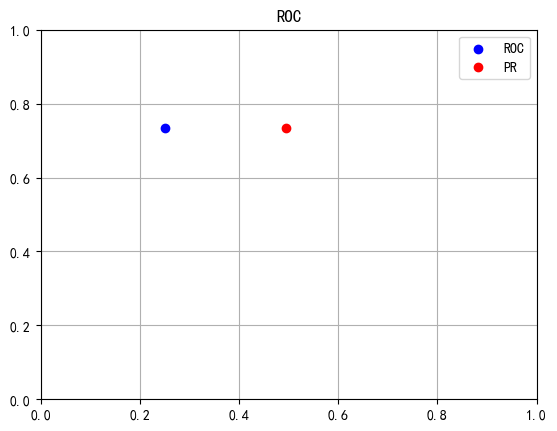

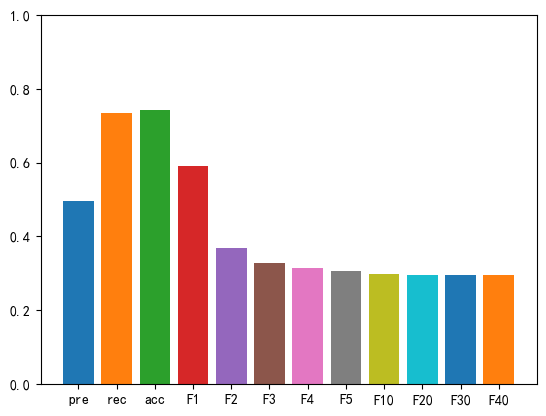

In [25]:
import matplotlib.pyplot as plt

plt.rcParams["font.sans-serif"]=['SimHei']
plt.rcParams["axes.unicode_minus"]=False

ROCy = argu['TP'] / (argu['TP'] + argu['FN'])
ROCx = argu['FP'] / (argu['FP'] + argu['TN'])

plt.scatter(ROCx, ROCy, color = 'blue', label = 'ROC')
plt.scatter(pre, rec, color = 'red', label = 'PR')
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc='best')
plt.grid()
plt.show()

plt.ylim([0,1])
for i in evaluation:
    #print(i)
    plt.bar(i[0], i[1])
plt.show()

{'TN': 12.0, 'FN': 9.0, 'FP': 188.0, 'TP': 191.0}
[('pre', 0.9408866995073891), ('rec', 0.955), ('acc', 0.5075), ('F1', 0.9478908188585607), ('F2', 0.5924317617866005), ('F3', 0.5266060104769782), ('F4', 0.5035669975186104), ('F5', 0.49290322580645163), ('F10', 0.4786848635235732), ('F20', 0.4751302729528536), ('F30', 0.4744720154397574), ('F40', 0.47424162531017366)]


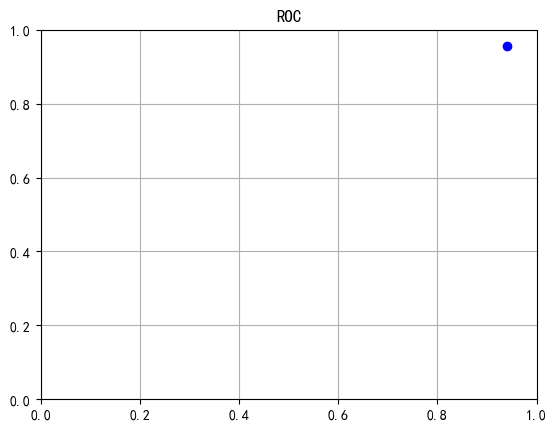

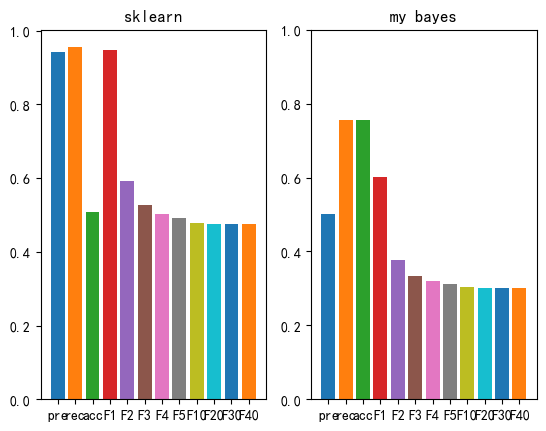

In [92]:
# 测试一下现有的库
from sklearn.naive_bayes import GaussianNB

BYS = GaussianNB(priors=None)

num_of_sen = len(train_set)
num_of_words = len(train_set[0][0])
# trainset[0][0]是一个dict
# transet[0][0] key 是1290个次
# transet[0][0] values 是 1290次是否存在在句子里面
# transet[0][1] 是句子的感情
# transet[0] 就是 [0]和[1]的tuple
# trainset 存1600个tuple

trainX = []
trainY = []

for i in range(num_of_sen):
    Num = [0] * (num_of_words) # 测试集设为0而非1
    tempList = list(train_set[i][0].values())
    for j in range(num_of_words):
        Num[j] += tempList[j]
    trainX.append(Num)
    trainY.append(train_set[i][1])
BYS.fit(trainX, trainY)


BYE_pre = (BYS.predict(TS))
four = [0.0] * 4
ref = dict(neg = 0, pos = 1)
for i in range(len(reality)):
    a = 2 * ref[BYE_pre[i]] + ref[reality[i]]
    # 实际占低
    four[a] += 1
argu = dict(zip(['TN', 'FN', 'FP', 'TP'], four))
print(argu)

evaluation1 = []
pre = argu['TP'] / (argu['TP'] + argu['TN'])
evaluation1.append(("pre", pre))
rec = argu['TP'] / (argu['TP'] + argu['FN'])
evaluation1.append(("rec", rec))
acc = (argu['TP'] + argu['TN'])/ sum(four)
evaluation1.append(("acc", acc))
# F1 = 2 * pre * rec / (pre + rec)
# evaluation.append(("F1", F1))

for a in list(range(1,6)) + list(range(10, 50, 10)) :
    F = ((a**2 + 1) * pre * rec) / (a**2 * (pre + rec))
    evaluation1.append(("F" + str(a), F))

print(evaluation1)
ROCy = argu['TP'] / (argu['TP'] + argu['FN'])
ROCx = argu['FP'] / (argu['FP'] + argu['TN'])

plt.scatter(ROCx, ROCy, color = 'blue', label = 'ROC')
#plt.scatter(pre, rec, color = 'red', label = 'PR')
# PR和ROC点重合了
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])
# plt.legend(loc='best')
plt.grid()
plt.show()

plt.subplot(121)
plt.title('sklearn')
for i in evaluation1:
    #print(i)
    plt.bar(i[0], i[1])
plt.subplot(122)
plt.title('my bayes')
plt.ylim(0,1)
for i in evaluation:
    #print(i)
    plt.bar(i[0], i[1])
plt.show()

# 总 结

自己实现的BAYES较为粗糙，还有很多参数设计不周到，最后导致拟合的性能远不及现有库的性能高效